# Intraday Renko OBV

1. Combination of Renko Charts and OBV Indicators
1. Choose high volume, high activity stocks for this strategy (pre-market movers, historically high volume stocks etc.)
1. Buy Signal
    1. Renko bar greater than or equal to 2 (two successive renko bar has formed)
    1. 5 day OBV slope greater than 30 degrees
    1. Exit if Renko bar is less than 2
1. Sell Signal
    1. Renko bar less than or equal to -2
    1. 5 day OBV slope less than -30 degrees
    1. Exit if Renko bar is greater than -2

In [1]:
import joblib
import numpy as np
import os
import pandas as pd
import time
from alpha_vantage.timeseries import TimeSeries

from RenkoOBV import RenkoOBV

In [2]:
os.chdir('./../3_TechnicalIndicators/')
from TechnicalIndicators import TechnicalIndicators

In [3]:
os.chdir('./../4_PerformanceMeasurement/')
from PerformanceMeasurements import PerformanceMeasurements

In [4]:
os.chdir('./../')
from Resources.APIKeys import APIKeys

In [5]:
ohlc_intraday = {}
api_call_count = 1
ts = TimeSeries(key=APIKeys.alpha_vantage, output_format='pandas')
start_time = time.time()
tickers = ['MSFT','AAPL','FB','AMZN','INTC', 'CSCO','VZ','IBM','TSLA','AMD']
# tickers = ['MSFT']

In [6]:
try:
    ohlc_intraday = joblib.load('del_ohlc_intraday.joblib')
except:
    for ticker in tickers:
        data = ts.get_intraday(symbol=ticker, interval='5min', outputsize='full')[0]
        api_call_count += 1
        data.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
        data = data[::-1]
        data = data.between_time('09:35', '16:00') # Some priviledged folks are allowed to trade outside trading hours
        ohlc_intraday[ticker] = data
        if api_call_count == 5:
            api_call_count = 1
            time.sleep(60 - ((time.time() - start_time) % 60.0))
    joblib.dump(ohlc_intraday, 'del_ohlc_intraday.joblib')
tickers = ohlc_intraday.keys()

In [7]:
ohlc_renko = {}
for ticker in tickers:
    ohlc = ohlc_intraday[ticker]
    renko = TechnicalIndicators.get_renko_df_alpha_vantage(ohlc, 0.5, True, 'Close')
    ohlc['Date'] = ohlc.index.values
    renko_sub = renko.reindex(columns = ['date', 'bar_num'])
    renko_sub.columns = ['Date', 'bar_num']
    ohlc_renko_df = ohlc.merge(renko_sub, how='outer', on='Date')
    ohlc_renko_df['bar_num'].fillna(method='ffill', inplace=True)
    TechnicalIndicators.add_obv(ohlc_renko_df, 'Close')
    ohlc_renko_df['obv_slope'] = TechnicalIndicators.calc_slope_v2(ohlc_renko_df['obv'], 5)
    ohlc_renko[ticker] = ohlc_renko_df

/anaconda/envs/py37_default/lib/python3.7/site-packages/stocktrends/indicators.py:58: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  self.cdf.loc[0, 1:] = [close - brick_size, close, close - brick_size, close]
/home/somesh/notebooks/Git/AlgorithmicTradingCourse/3_TechnicalIndicators/TechnicalIndicators.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['direction'][0] = 0
/anaconda/envs/py37_default/lib/python3.7/site-packages/stocktrends/indicators.py:58: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  self.cdf.loc[0, 1:] = [close - brick_size, clos

In [8]:
ohlc_renko_df

,Open,High,Low,Close,Volume,TR,ATR,roll_max_cp,roll_min_cp,roll_max_vol,ret,Date,bar_num,obv,obv_slope
120,90.1369,90.5200,90.0700,90.4299,865584.0,0.4500,0.269640,92.1200,89.610,1781971.0,-0.003095,2021-02-17 09:50:00,-3.0,-6499634.0,0.000000
121,90.4300,90.6199,90.1500,90.2765,783853.0,0.4699,0.270514,92.1200,89.610,1781971.0,0.001699,2021-02-17 09:55:00,-3.0,-7283487.0,0.000000
122,90.2900,90.4500,89.8701,89.9099,546088.0,0.5799,0.273097,92.1067,89.610,1781971.0,0.004077,2021-02-17 10:00:00,-3.0,-7829575.0,0.000000
123,89.8950,90.0586,89.6400,89.6450,666533.0,0.4186,0.274502,92.1050,89.610,1781971.0,0.002955,2021-02-17 10:05:00,-3.0,-8496108.0,0.000000
124,89.6500,90.1999,89.4900,89.9800,1043762.0,0.7099,0.278184,92.1050,89.490,1781971.0,-0.003723,2021-02-17 10:10:00,-3.0,-7452346.0,-31.993448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1516,81.0100,81.1900,80.9706,81.1300,402398.0,0.2194,0.252965,81.1900,80.645,402398.0,-0.001479,2021-03-12 15:40:00,1.0,-28071278.0,38.691916
1517,81.1200,81.1200,80.9100,80.9900,453937.0,0.2200,0.253215,81.1900,80.645,453937.0,0.001729,2021-03-12 15:45:00,1.0,-28525215.0,18.563546
1518,80.9900,81.0500,80.9000,80.9000,422412.0,0.1500,0.252590,81.1900,80.645,453937.0,0.001112,2021-03-12 15:50:00,1.0,-28947627.0,-14.234921
1519,80.9000,80.9700,80.8150,80.8600,614723.0,0.1550,0.251965,81.1900,80.645,614723.0,0.000495,2021-03-12 15:55:00,1.0,-29562350.0,-39.324164


In [9]:
RenkoOBV.calculate_returns(ohlc_renko, 'Close')

In [10]:
strategy_df = pd.DataFrame()
for ticker in tickers:
    strategy_df[ticker] = ohlc_renko[ticker]['ret']
strategy_df['ret'] = strategy_df.mean(axis=1)

In [11]:
print(PerformanceMeasurements.get_cagr_for_returns(strategy_df['ret'].values, 252*78))
print(PerformanceMeasurements.get_sharpe_ratio_for_returns(strategy_df['ret'].values, 252*78, 0.025))
print(PerformanceMeasurements.get_max_drawdown_for_returns(strategy_df['ret'].values))

0.12256404487309824
0.56907530845829
0.04702264881009616


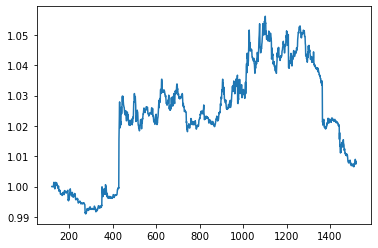

In [12]:
(1+strategy_df['ret']).cumprod().plot();

In [13]:
cagr = {}
sharpe_ratios = {}
max_drawdowns = {}
for ticker in tickers:
    ohlc = ohlc_intraday[ticker]
    cagr[ticker] = PerformanceMeasurements.get_cagr_for_returns(ohlc['ret'].values, 252*78)
    sharpe_ratios[ticker] = PerformanceMeasurements.get_sharpe_ratio_for_returns(ohlc['ret'].values, 252*78, 0.025)
    max_drawdowns[ticker] = PerformanceMeasurements.get_max_drawdown_for_returns(ohlc['ret'].values)

In [14]:
KPI_df = pd.DataFrame([cagr, sharpe_ratios, max_drawdowns], index=['Return', 'Sharpe Ratio', 'Max Drawdowns'])
KPI_df.T

,Return,Sharpe Ratio,Max Drawdowns
MSFT,0.021462,-0.013854,0.061302
AAPL,1.979104,5.488670,0.062512
FB,0.303922,0.803234,0.087339
AMZN,0.836632,2.553118,0.075719
INTC,-0.398763,-1.515621,0.095142
CSCO,-0.415607,-1.852471,0.098899
VZ,0.100434,0.387788,0.049307
IBM,-0.313877,-2.128259,0.047196
TSLA,1.379252,1.494252,0.231998
AMD,1.399388,3.140901,0.096959
